In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/TSLA.csv'

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
data = pd.read_csv(path)

In [ ]:
start_date = '2015-01-01'
end_date = '2020-12-31'

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
data_1 = data[(data['Date']>= start_date) & (data['Date']<= end_date)]

In [ ]:
final_data = data_1[['Date','Adj Close']]

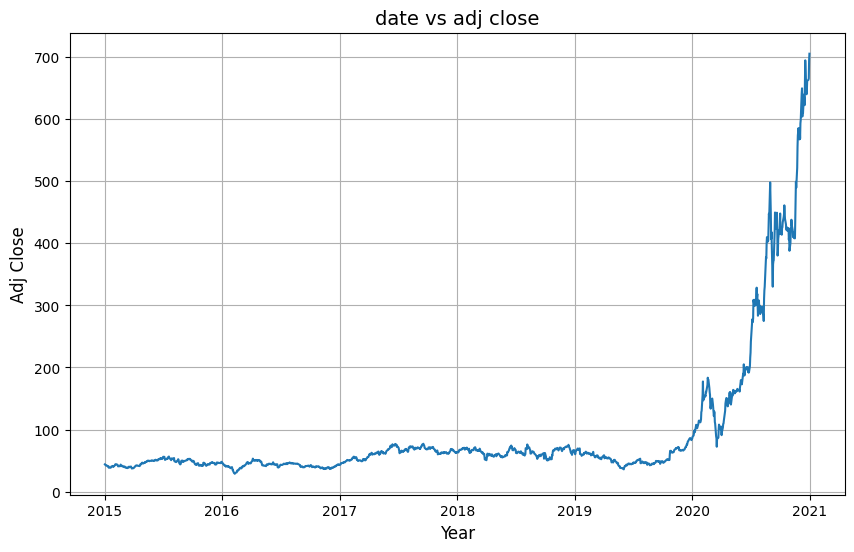

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(final_data['Date'],final_data['Adj Close'])
plt.title('date vs adj close', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Adj Close', fontsize=12)
plt.grid(True)
plt.show()

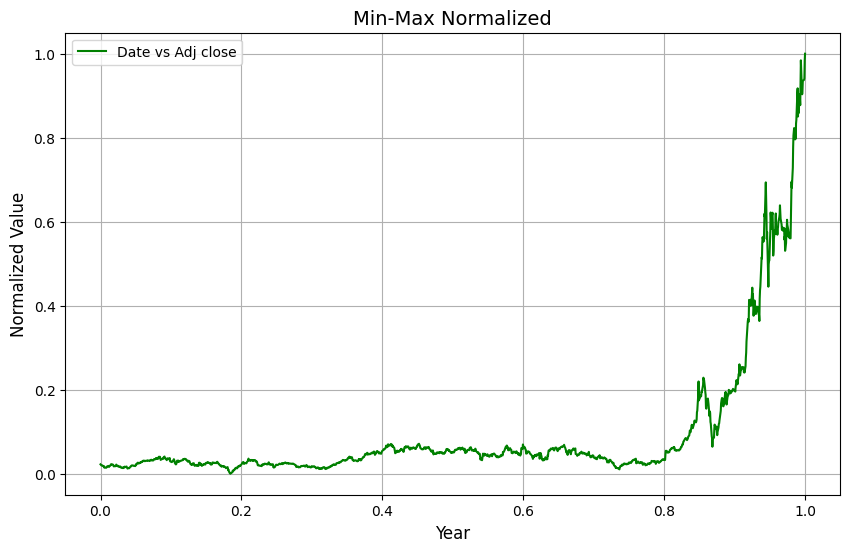

In [ ]:
data_norm = final_data.copy()
data_norm["date_numeric"] = pd.to_datetime(data_norm["Date"]).map(lambda x: x.toordinal())
data_norm["date_normalized"] = (data_norm["date_numeric"] - data_norm["date_numeric"].min()) / (data_norm["date_numeric"].max() - data_norm["date_numeric"].min())
data_norm["adj_close_normalized"] = (data_norm["Adj Close"] - data_norm["Adj Close"].min()) / (data_norm["Adj Close"].max() - data_norm["Adj Close"].min())
data_norm.describe()
plt.figure(figsize=(10, 6))
plt.plot(data_norm["date_normalized"],data_norm["adj_close_normalized"], color='g', label='Date vs Adj close')
plt.title('Min-Max Normalized', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
data_norm.describe()

,Date,Adj Close,date_numeric,date_normalized,adj_close_normalized
count,1511,1511.000000,1511.000000,1511.000000,1511.000000
mean,2018-01-01 13:09:05.598941184,93.335042,736695.547981,0.500250,0.095432
min,2015-01-02 00:00:00,28.733999,735600.000000,0.000000,0.000000
25%,2016-07-03 00:00:00,45.424000,736148.000000,0.250228,0.024655
50%,2018-01-02 00:00:00,56.835999,736696.000000,0.500457,0.041514
75%,2019-07-04 00:00:00,69.494999,737244.000000,0.750685,0.060214
max,2020-12-31 00:00:00,705.669983,737790.000000,1.000000,1.000000
std,NaN,112.492452,633.100127,0.289087,0.166179


Text(0.5, 1.0, 'Autocorrelation PACF')

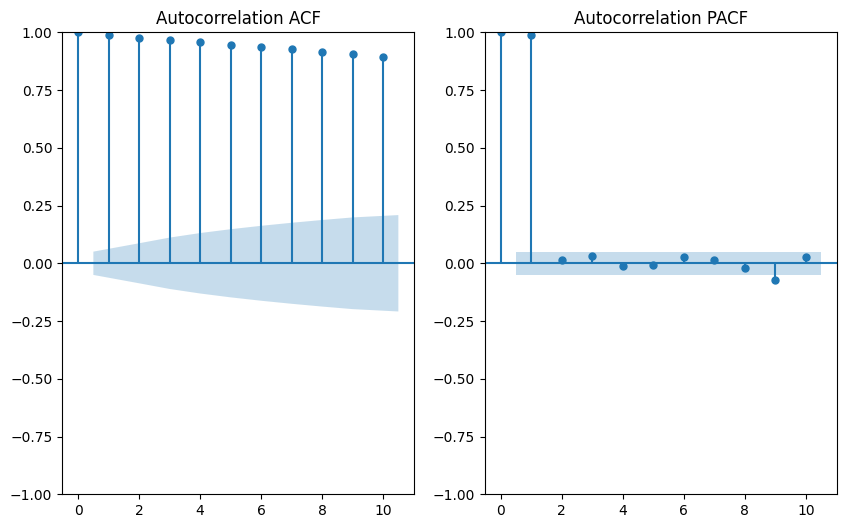

In [ ]:
analysis_data = final_data["Adj Close"]
plt.figure(figsize = (10,6))
plt.subplot(1,2,1)
plot_acf(analysis_data,lags=10,ax=plt.gca())
plt.title("Autocorrelation ACF")
plt.subplot(1,2,2)
plot_pacf(analysis_data,lags=10,ax=plt.gca(),method="ywm")
plt.title("Autocorrelation PACF")

In [ ]:
def check_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] < 0.05:
        print("The series is stationary (reject null hypothesis).")
    else:
        print("The series is not stationary (fail to reject null hypothesis).")

In [ ]:
check_stationarity(analysis_data)

ADF Statistic: 6.4983341974147
p-value: 1.0
Critical Values: {'1%': -3.434755261885587, '5%': -2.863485639173984, '10%': -2.567805836609504}
The series is not stationary (fail to reject null hypothesis).


In [ ]:
analysis_data_diff = analysis_data.diff().dropna()
check_stationarity(analysis_data_diff)

ADF Statistic: -7.183072065806269
p-value: 2.6191190036964573e-10
Critical Values: {'1%': -3.434755261885587, '5%': -2.863485639173984, '10%': -2.567805836609504}
The series is stationary (reject null hypothesis).


In [ ]:
train_data = final_data[(final_data['Date'] >= '2015-01-01') & (final_data['Date'] <= '2020-05-31')]
test_data = final_data[(final_data['Date'] >= '2020-06-01') & (final_data['Date'] <= '2020-12-31')]
print(type(train_data.index))
print(type(test_data.index))


<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.base.Index'>


In [ ]:
train_data.index = pd.to_datetime(train_data['Date'])
test_data.index = pd.to_datetime(test_data['Date'])
print(type(train_data.index))
print(type(test_data.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [ ]:
auto_arima_1 = auto_arima(train_data['Adj Close'], seasonal=False, stepwise=False)
auto_arima_1

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True)

In [ ]:
model = ARIMA(train_data['Adj Close'], order=(3, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1361
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3285.734
Date:                Mon, 09 Dec 2024   AIC                           6583.467
Time:                        18:02:15   BIC                           6614.759
Sample:                             0   HQIC                          6595.182
                               - 1361                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5204      0.016    -96.314      0.000      -1.551      -1.489
ar.L2         -0.8179      0.019    -43.933      0.000      -0.854      -0.781
ar.L3          0.0885      0.008     11.185      0.0

In [ ]:
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq='B')
forecast_values = forecast.values if isinstance(forecast, pd.Series) else forecast
forecast_df = pd.DataFrame(forecast_values,index=forecast_index,columns=['Adj Close'])
#print(forecast)
forecast_df.head()
#forecast_df.tail()

,Adj Close
2020-06-01,167.417308
2020-06-02,168.115866
2020-06-03,167.228953
2020-06-04,168.042996
2020-06-05,167.592533


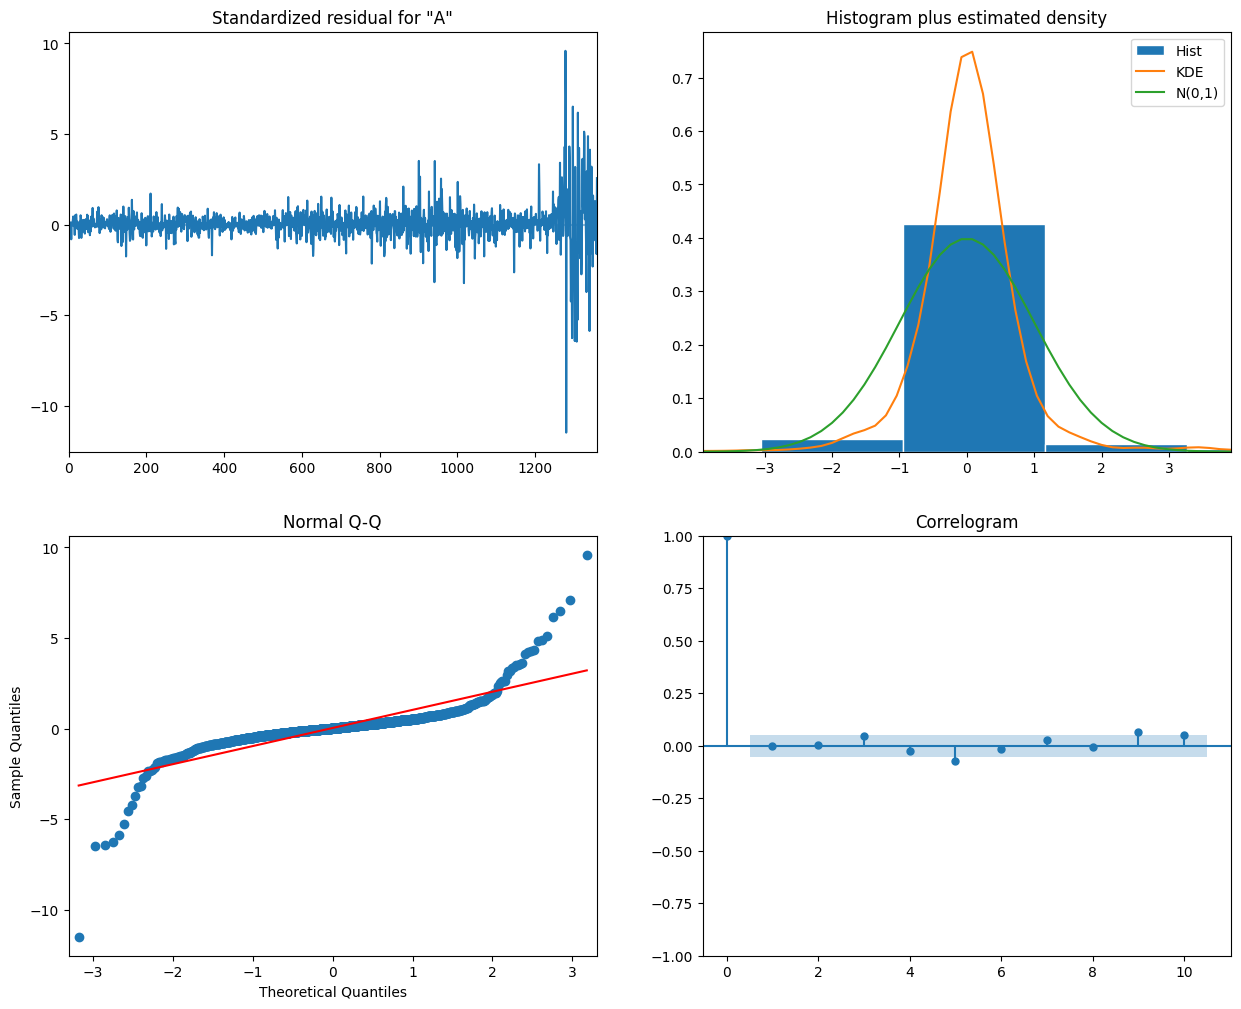

In [ ]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

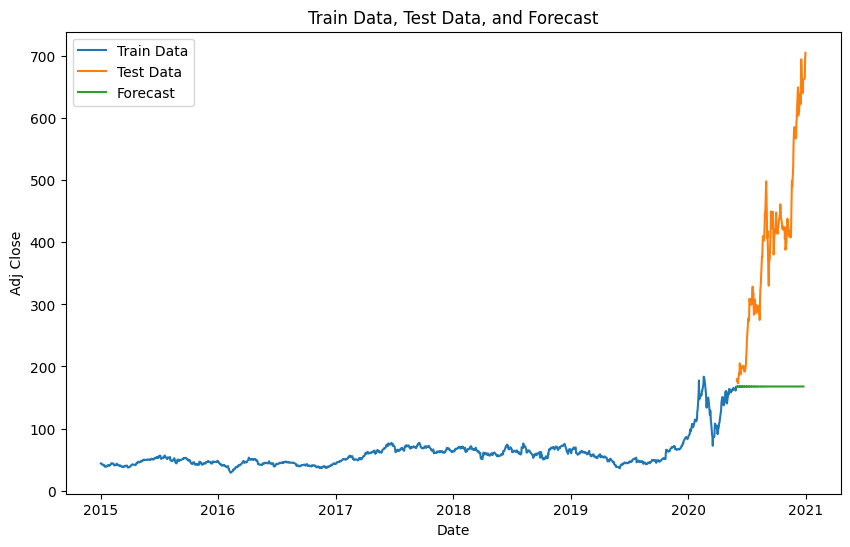

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_data['Adj Close'], label='Train Data')
plt.plot(test_data['Adj Close'], label='Test Data')
plt.plot(forecast_df['Adj Close'], label='Forecast')
plt.legend()
plt.title('Train Data, Test Data, and Forecast')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()


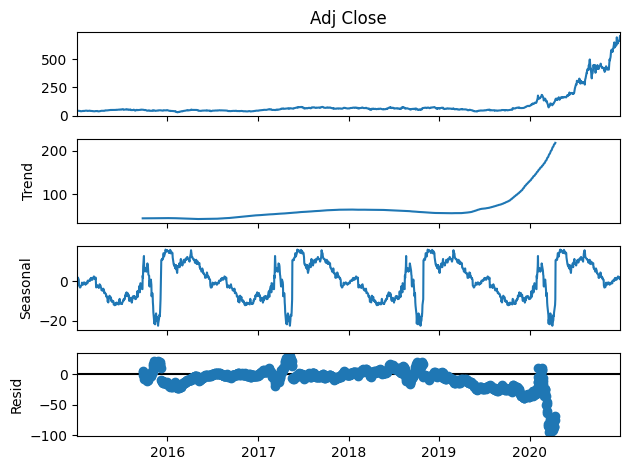

In [ ]:
final_data.index = pd.to_datetime(final_data['Date'])
seasonal_decompose(final_data['Adj Close'], model='additive',period=365).plot()
plt.show()

In [ ]:
auto_arima_model = auto_arima(train_data['Adj Close'],d=1,D=1, seasonal=True, m=12, trace=True, suppress_warnings=True,stepwise=True)
#auto_arima_model.fit(train_data['Adj Close'])
auto_arima_model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=19.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7353.800, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7081.301, Time=1.77 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=7355.566, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=6942.836, Time=1.21 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.85 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.08 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=6940.836, Time=2.16 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=7079.476, Time=0.72 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=5.25 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=6942.836, Time=1.27 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=19.49 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=6942.770,

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
sarimax_model = SARIMAX(train_data['Adj Close'], order=(0, 1, 0), seasonal_order=(2, 1, 0, 12))
sarimax_model_fit = sarimax_model.fit()
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                 1361
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -3467.418
Date:                            Mon, 09 Dec 2024   AIC                           6940.836
Time:                                    18:03:31   BIC                           6956.456
Sample:                                         0   HQIC                          6946.686
                                           - 1361                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5728      0.010    -57.633      0.000      -0.592      -0.553
ar.S.L24      -0.3298      0.012   

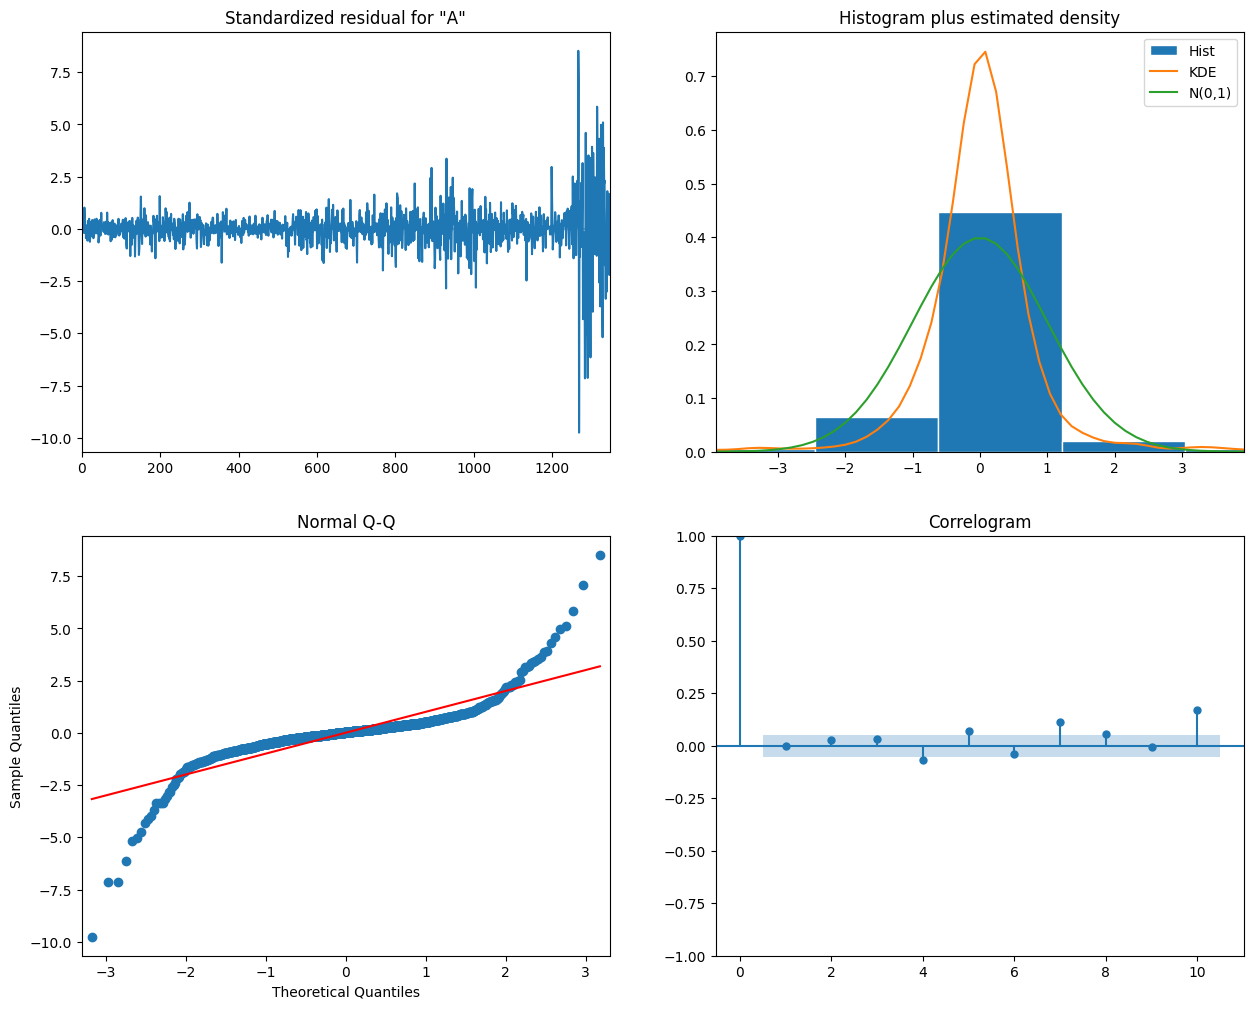

In [ ]:
sarimax_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
sarimax_forecast = sarimax_model_fit.get_forecast(steps=6)
sarimax_forecast_df = sarimax_forecast.conf_int()
sarimax_forecast_df['mean'] = sarimax_forecast.predicted_mean
print(sarimax_forecast_df)

      lower Adj Close  upper Adj Close        mean
1361       163.025919       175.423016  169.224467
1362       161.668911       179.201054  170.434982
1363       166.011167       187.483570  176.747368
1364       168.568307       193.362501  180.965404
1365       164.025004       191.745756  177.885380
1366       167.271435       197.637997  182.454716


In [ ]:
sarima_forecast_steps = len(test_data)
sarima_forecast = sarimax_model_fit.forecast(steps=sarima_forecast_steps)
sarima_forecast_index = pd.date_range(start=test_data.index[0], periods=sarima_forecast_steps, freq='B')
sarima_forecast_df = sarimax_forecast.conf_int()
sarima_forecast_df['mean'] = sarimax_forecast.predicted_mean
sarima_forecast_values = sarima_forecast.values if isinstance(sarima_forecast, pd.Series) else sarima_forecast
sarima_forecast_df_1 = pd.DataFrame(sarima_forecast_values,index=sarima_forecast_index,columns=['Adj Close'])
#print(forecast)
sarima_forecast_df_1.head()

,Adj Close
2020-06-01,169.224467
2020-06-02,170.434982
2020-06-03,176.747368
2020-06-04,180.965404
2020-06-05,177.885380


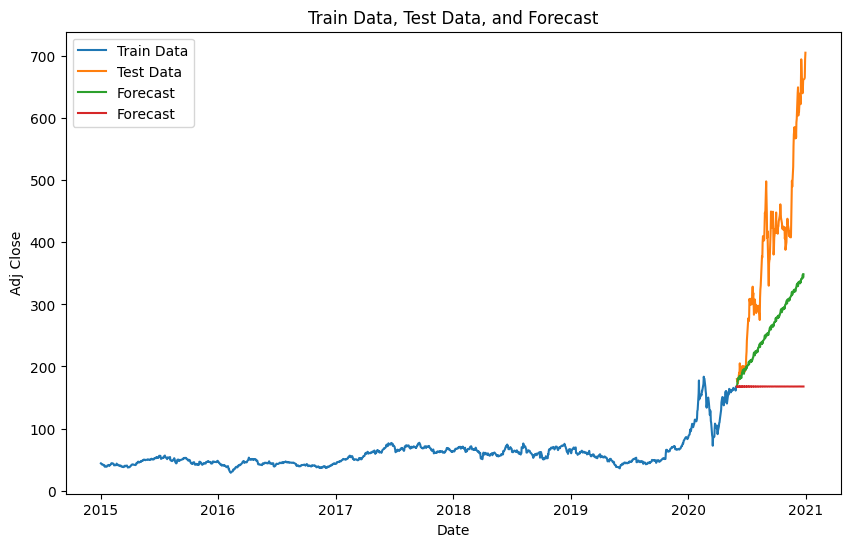

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_data['Adj Close'], label='Train Data')
plt.plot(test_data['Adj Close'], label='Test Data')
plt.plot(sarima_forecast_df_1['Adj Close'], label='Forecast')
plt.plot(forecast_df['Adj Close'], label='Forecast')
plt.legend()
plt.title('Train Data, Test Data, and Forecast')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

In [ ]:
# Reset the index to have 'Date' as a column if needed:
forecast_df.reset_index(inplace=True)
forecast_df.rename(columns={'index': 'Date'}, inplace=True)
# Now you can set 'Date' as the index:
forecast_df.set_index('Date', inplace=True)


# Save the DataFrame with the index
forecast_df.to_csv('/content/drive/MyDrive/forecast_df.csv', index=True)

In [ ]:
sarima_forecast_steps = len(test_data)
sarima_forecast = sarimax_model_fit.forecast(steps=sarima_forecast_steps)
sarima_forecast_index = pd.date_range(start=test_data.index[0], periods=sarima_forecast_steps, freq='B')

# Instead of accessing 'predicted_mean', use the values directly from sarima_forecast
forecast_values = sarima_forecast

# Create sarima_forecast_df_1 with 'Adj Close' and the index
sarima_forecast_df_1 = pd.DataFrame({'Adj Close': sarima_forecast_values}, index=sarima_forecast_index)

# Rename the index to 'Date'
sarima_forecast_df_1.index.name = 'Date'

# Reset the index to make the timestamp a regular column
sarima_forecast_df_1 = sarima_forecast_df_1.reset_index()

# Convert the 'Date' column to datetime objects and format as 'YYYY-MM-DD'
sarima_forecast_df_1['Date'] = pd.to_datetime(sarima_forecast_df_1['Date']).dt.strftime('%Y-%m-%d')

# Now save to CSV
sarima_forecast_df_1.to_csv('/content/drive/MyDrive/sarima_forecast.csv', index=False)